In [11]:
import os

from abc import ABC, abstractmethod
import torch
from torchvision import datasets, transforms  # FUNCIONA
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ LIMPIO | PyTorch: {torch.__version__} | GPU: {torch.cuda.get_device_name(0)}")



✅ LIMPIO | PyTorch: 2.9.1+cu128 | GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Carga SIN matplotlib (solo datos)
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # batch MUY pequeño
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print("✅ Datos cargados")
print(f"Train: {len(train_data)} imágenes")
print(f"Test:  {len(test_data)} imágenes")



✅ Datos cargados
Train: 60000 imágenes
Test:  10000 imágenes


In [3]:
# ✅ SIN MATPLOTLIB - 100% SEGURO
print("🔍 Verificando datos...")
dataiter = iter(test_loader)
images, labels = next(dataiter)

print(f"✅ Batch cargado: {images.shape} imágenes")
print(f"✅ Labels: {labels[:5].tolist()}")  # Primeros 5 labels
print(f"✅ Rango píxeles imagen 0: [{images[0].min():.3f}, {images[0].max():.3f}]")
print("✅ TODO OK - datos listos para autoencoder!")



🔍 Verificando datos...
✅ Batch cargado: torch.Size([16, 1, 28, 28]) imágenes
✅ Labels: [7, 2, 1, 0, 4]
✅ Rango píxeles imagen 0: [0.000, 1.000]
✅ TODO OK - datos listos para autoencoder!


In [4]:
# ==========================
# Modelo base: AutoencoderConv
# ==========================

class AutoencoderConv(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 28x28 -> 14x14 -> 7x7 -> 1x1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # N,16,14,14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # N,32,7,7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),                       # N,64,1,1
            nn.ReLU()
        )
        # Decoder: 1x1 -> 7x7 -> 14x14 -> 28x28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),                             # N,32,7,7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1,
                               output_padding=1),                                   # N,16,14,14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1),         # N,1,28,28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Reescalar la salida a (N, 1, 28, 28) por seguridad ya que daba error de dimension porque salia en 27
        decoded_resized = nn.functional.interpolate(decoded, size=(28,28), mode='bilinear', align_corners=False)
        return decoded_resized



In [5]:
# ==========================
# Factory para crear modelos
# ==========================

class ModelFactory:
    @staticmethod
    def create_denoising_autoencoder(device):
        model = AutoencoderConv().to(device)
        return model

    @staticmethod
    def create_super_resolution_autoencoder(device):
        # Para super-resolución reutilizamos la misma arquitectura 28x28->28x28.
        # La "baja resolución" se simula en los datos (downsampling), no cambiando el modelo.
        model = AutoencoderConv().to(device)
        return model



In [6]:
# ==========================
# Servicio de entrenamiento
# ==========================

class TrainerService:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train(self, dataloader, num_epochs, transform_input, transform_target):
        self.model.train()
        history = []
        for epoch in range(num_epochs):
            running_loss = 0.0
            for imgs, _ in dataloader:
                imgs = imgs.to(self.device)

                # Aplicar estrategias de transformación de entrada/target (Strategy)
                inputs = transform_input(imgs)
                targets = transform_target(imgs)

                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * imgs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            history.append(epoch_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.6f}")
        return history



### Servicio de visualización (matriz 3×N)

In [7]:

# ==========================
# Servicio de visualización
# ==========================

class VisualizationService:
    @staticmethod
    def show_triplet_grid(originals, corrupted, reconstructions, num_images=10, title=""):
        originals = originals[:num_images].cpu().numpy()
        corrupted = corrupted[:num_images].cpu().numpy()
        reconstructions = reconstructions[:num_images].cpu().detach().numpy()

        plt.figure(figsize=(num_images, 3))
        plt.suptitle(title)

        # Fila 1: originales
        for i in range(num_images):
            plt.subplot(3, num_images, i + 1)
            plt.imshow(originals[i].squeeze(), cmap="gray")
            plt.axis("off")

        # Fila 2: corruptas / baja resolución
        for i in range(num_images):
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(corrupted[i].squeeze(), cmap="gray")
            plt.axis("off")

        # Fila 3: reconstruidas
        for i in range(num_images):
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(reconstructions[i].squeeze(), cmap="gray")
            plt.axis("off")

        plt.show()



In [12]:
# ==========================
# Strategy para tareas
# ==========================

class AutoencoderTask(ABC):
    @abstractmethod
    def transform_input(self, imgs):
        pass

    @abstractmethod
    def transform_target(self, imgs):
        pass

    @abstractmethod
    def title(self):
        pass


### Tarea 1: Eliminación de ruido (Denoising)

In [13]:
# ==========================
# Tarea: Denoising
# ==========================

class DenoisingTask(AutoencoderTask):
    def __init__(self, device, noise_std=0.4):
        self.device = device
        self.noise_std = noise_std

    def transform_input(self, imgs):
        # Añadir ruido gaussiano a la entrada, clip a [0,1]
        noise = torch.randn_like(imgs) * self.noise_std
        noisy_imgs = torch.clamp(imgs + noise, 0.0, 1.0)
        return noisy_imgs.to(self.device)

    def transform_target(self, imgs):
        # Objetivo: imagen limpia
        return imgs.to(self.device)

    def title(self):
        return "Autoencoder de eliminación de ruido"


# Entrenamiento denoising
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

model_denoise = ModelFactory.create_denoising_autoencoder(device)
optimizer_denoise = torch.optim.Adam(model_denoise.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

denoising_task = DenoisingTask(device, noise_std=0.4)
trainer_denoise = TrainerService(model_denoise, optimizer_denoise, loss_fn, device)

history_denoise = trainer_denoise.train(
    dataloader=train_loader,
    num_epochs=10,
    transform_input=denoising_task.transform_input,
    transform_target=denoising_task.transform_target
)


Epoch 1/10 - Loss: 0.048637
Epoch 2/10 - Loss: 0.018951
Epoch 3/10 - Loss: 0.014964
Epoch 4/10 - Loss: 0.013342
Epoch 5/10 - Loss: 0.012403
Epoch 6/10 - Loss: 0.011793
Epoch 7/10 - Loss: 0.011390
Epoch 8/10 - Loss: 0.011153
Epoch 9/10 - Loss: 0.010979
Epoch 10/10 - Loss: 0.010854


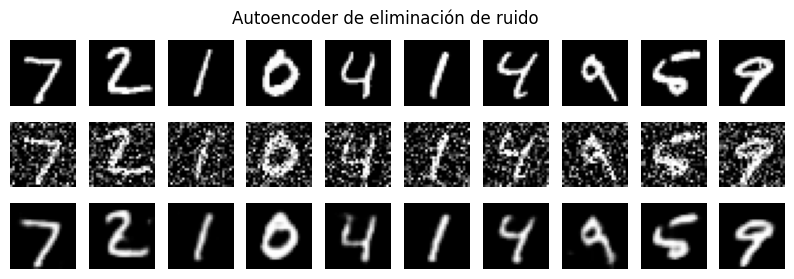

In [15]:
model_denoise.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    noisy = denoising_task.transform_input(imgs)
    recon = model_denoise(noisy)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=noisy,
    reconstructions=recon,
    num_images=10,
    title=denoising_task.title()
)


### Tarea 2: Super–resolución 7×7 y 14×14 → 28×28
Aquí no se cambia el modelo; se cambia la “estrategia” de entrada/objetivo: se genera una versión 7×7 o 14×14 a partir de la 28×28, se reescala de vuelta a 28×28 (interpolación) y el autoencoder aprende a mapear esa imagen “borrosa” a la original.​



In [16]:
# ==========================
# Utilidades de downsample / upsample
# ==========================

def downsample_to_size(x, out_size):
    # x: [B,1,28,28], out_size: int (7 o 14)
    return torch.nn.functional.interpolate(x, size=(out_size, out_size), mode="bilinear", align_corners=False)

def upsample_to_28(x):
    return torch.nn.functional.interpolate(x, size=(28, 28), mode="bilinear", align_corners=False)


# ==========================
# Tarea: Super-resolución
# ==========================

class SuperResolutionTask(AutoencoderTask):
    def __init__(self, device, low_res_size):
        assert low_res_size in (7, 14)
        self.device = device
        self.low_res_size = low_res_size

    def transform_input(self, imgs):
        # 28x28 -> low_res (7/14) -> upsample a 28x28
        low = downsample_to_size(imgs, self.low_res_size)
        low_up = upsample_to_28(low)
        return low_up.to(self.device)

    def transform_target(self, imgs):
        # Objetivo: imagen original 28x28
        return imgs.to(self.device)

    def title(self):
        return f"Autoencoder super-resolución ({self.low_res_size}x{self.low_res_size} -> 28x28)"


# Entrenamiento super-resolución 7x7
model_sr7 = ModelFactory.create_super_resolution_autoencoder(device)
optimizer_sr7 = torch.optim.Adam(model_sr7.parameters(), lr=1e-3, weight_decay=1e-5)
sr7_task = SuperResolutionTask(device, low_res_size=7)
trainer_sr7 = TrainerService(model_sr7, optimizer_sr7, loss_fn, device)

history_sr7 = trainer_sr7.train(
    dataloader=train_loader,
    num_epochs=10,
    transform_input=sr7_task.transform_input,
    transform_target=sr7_task.transform_target
)

# Entrenamiento super-resolución 14x14
model_sr14 = ModelFactory.create_super_resolution_autoencoder(device)
optimizer_sr14 = torch.optim.Adam(model_sr14.parameters(), lr=1e-3, weight_decay=1e-5)
sr14_task = SuperResolutionTask(device, low_res_size=14)
trainer_sr14 = TrainerService(model_sr14, optimizer_sr14, loss_fn, device)

history_sr14 = trainer_sr14.train(
    dataloader=train_loader,
    num_epochs=10,
    transform_input=sr14_task.transform_input,
    transform_target=sr14_task.transform_target
)



Epoch 1/10 - Loss: 0.041252
Epoch 2/10 - Loss: 0.024746
Epoch 3/10 - Loss: 0.022722
Epoch 4/10 - Loss: 0.021624
Epoch 5/10 - Loss: 0.020896
Epoch 6/10 - Loss: 0.020363
Epoch 7/10 - Loss: 0.019936
Epoch 8/10 - Loss: 0.019563
Epoch 9/10 - Loss: 0.019304
Epoch 10/10 - Loss: 0.019045
Epoch 1/10 - Loss: 0.035390
Epoch 2/10 - Loss: 0.012166
Epoch 3/10 - Loss: 0.009281
Epoch 4/10 - Loss: 0.008009
Epoch 5/10 - Loss: 0.007275
Epoch 6/10 - Loss: 0.006827
Epoch 7/10 - Loss: 0.006522
Epoch 8/10 - Loss: 0.006301
Epoch 9/10 - Loss: 0.006151
Epoch 10/10 - Loss: 0.006025


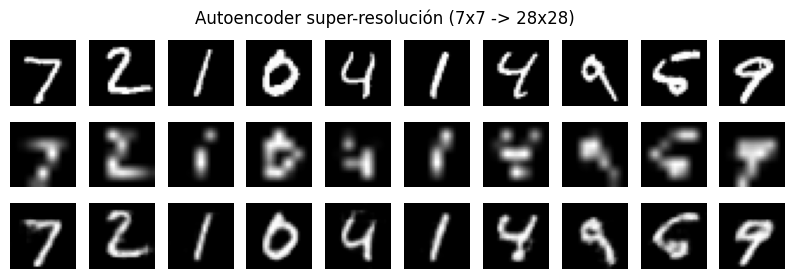

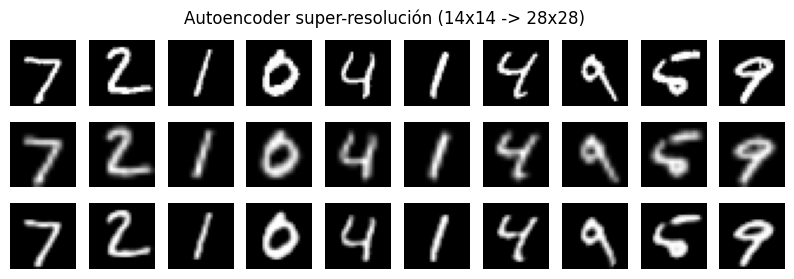

In [17]:
# Visualización super-resolución 7x7
model_sr7.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    low = downsample_to_size(imgs, 7)
    low_up = upsample_to_28(low)
    recon7 = model_sr7(low_up)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=low_up,
    reconstructions=recon7,
    num_images=10,
    title=sr7_task.title()
)

# Visualización super-resolución 14x14
model_sr14.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    low14 = downsample_to_size(imgs, 14)
    low14_up = upsample_to_28(low14)
    recon14 = model_sr14(low14_up)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=low14_up,
    reconstructions=recon14,
    num_images=10,
    title=sr14_task.title()
)
